<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/2D_RESNET18_BC_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#2D slices + ResNet18

0 → CN (Not Alzheimer's)

1 → Alzheimer's (AD, LMCI, EMCI)

```
# 69.66% ACC achivied
```



get tha dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the nifti

In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/MRI_DATASET/nifti.zip'
extract_path = '/content/drive/MyDrive/MRI_DATASET/nifti'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Load the central slices of the brain

In [9]:
from time import time

In [4]:
import os
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
from torchvision import transforms
from PIL import Image

class MRISliceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        # Mapping: CN -> 0, AD/EMCI/LMCI -> 1
        class_map = {'CN': 0, 'AD': 1, 'EMCI': 1, 'LMCI': 1}
        for cls in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(class_dir): continue
            for subj in os.listdir(class_dir):
                subj_dir = os.path.join(class_dir, subj)
                if not os.path.isdir(subj_dir): continue
                for f in os.listdir(subj_dir):
                    if f.endswith('.nii') or f.endswith('.nii.gz'):
                        self.samples.append((os.path.join(subj_dir, f), class_map[cls]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        # Take central axial slice
        slice_idx = img.shape[2] // 2
        slice_img = img[:, :, slice_idx]
        # Normalize to 0-255 and convert to PIL image
        slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
        slice_img = (slice_img * 255).astype(np.uint8)
        pil_img = Image.fromarray(slice_img)
        pil_img = pil_img.convert('RGB')  # ResNet expects 3 channels
        if self.transform:
            pil_img = self.transform(pil_img)
        return pil_img, label


Define transformer

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = MRISliceDataset('/content/drive/MyDrive/MRI_DATASET/nifti/nifti', transform=transform)
from torch.utils.data import random_split, DataLoader

train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)


load the ResNet Model

In [7]:
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.6MB/s]


Training

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):  # Increase epochs as needed
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 0.5875
Epoch 2, Loss: 0.2537
Epoch 3, Loss: 0.1016
Epoch 4, Loss: 0.0491
Epoch 5, Loss: 0.0381


Validation

In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 69.66%


#For visualization

In [12]:
#for visualization

import matplotlib.pyplot as plt

model.eval()
images_list = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # Move tensors to CPU and convert to numpy for visualization
        for i in range(images.size(0)):
            img = images[i].cpu().numpy().transpose(1, 2, 0)  # CHW to HWC
            img = (img * 0.5 + 0.5) * 255  # Unnormalize if you used Normalize([0.5]*3, [0.5]*3)
            img = img.astype('uint8')
            images_list.append(img)
            true_labels.append(labels[i].cpu().item())
            pred_labels.append(predicted[i].cpu().item())



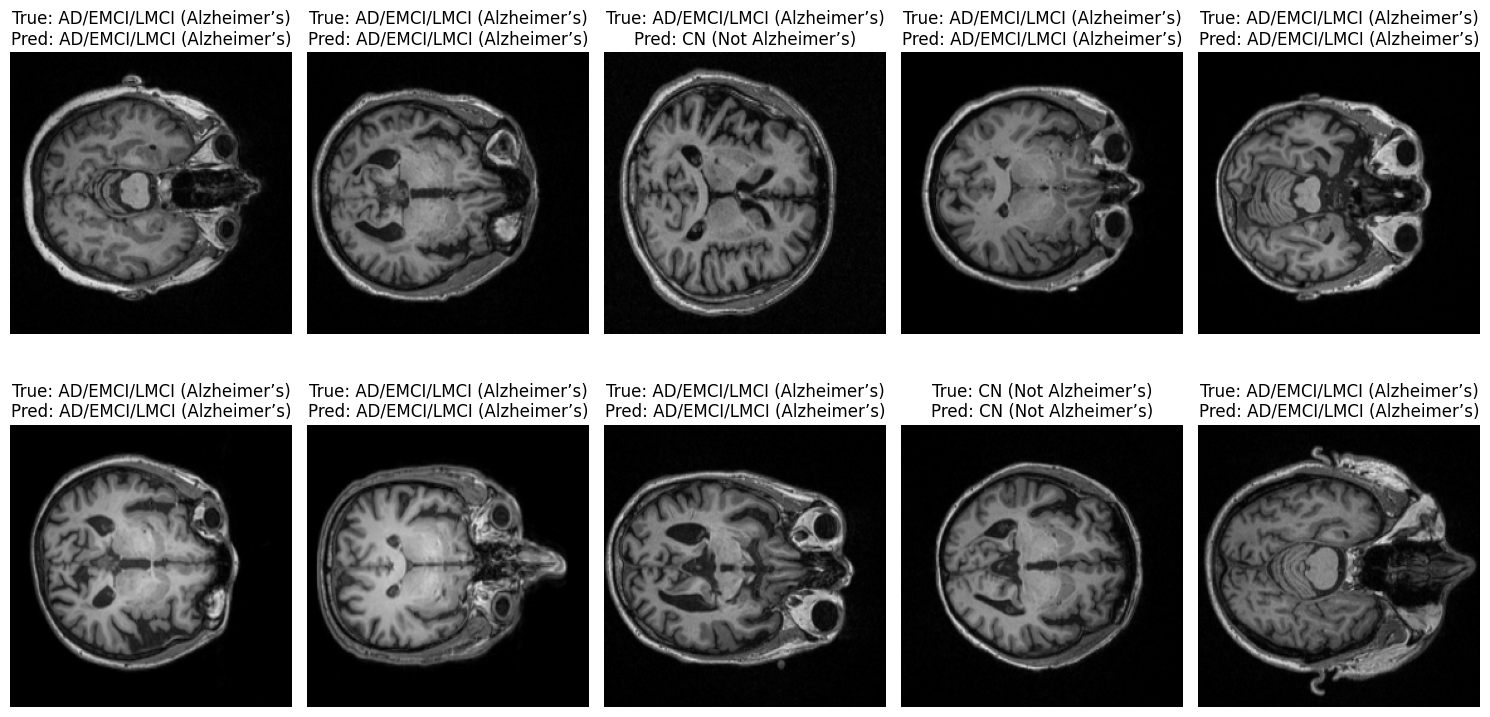

In [13]:
class_names = {0: "CN (Not Alzheimer’s)", 1: "AD/EMCI/LMCI (Alzheimer’s)"}

num_examples = 10  # Number of images to show
plt.figure(figsize=(15, 8))
for idx in range(num_examples):
    plt.subplot(2, 5, idx+1)
    plt.imshow(images_list[idx])
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
